In [1]:
%matplotlib inline
# %load_ext autotime

import numpy as np
import pandas as pd
import sklearn
import pprint
import shap

shap.initjs()

import build_data, build_model, make_features_labels, plot_diagnostics, compute_metrics, save_load_model

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import importlib as imp

import experiment_settings

dpiFig = 600
mpl.rcParams["figure.dpi"] = 100
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
plt.style.use("seaborn-white")

#colors = ("#6c757d","#009969","#8b0053","#ff9c23","#00639a","#9359ba","#a0b2cd","#96bd52","#847149","#c45245")

In [2]:
colors = ["#6c757d","#009969","#8b0053","#ff9c23","#00639a","#9359ba","#a0b2cd","#96bd52","#847149","#c45245"]

# Setup the experiment

In [3]:
EXP_NAME = 'exp000'
SAVE_MODEL = True
SAVE_METRICS = True
#---------------------------------------------------------------
# setup the experiment you want to run in experiment_settings.py
settings = experiment_settings.get_settings(EXP_NAME)
settings

{'model_type': 'logistic_regression',
 'predictand': 'label_cyclogensis_boolean',
 'years': (1979, 2021),
 'storm_type': 'first_tropicalstorm',
 'len_rolling_sum': 7,
 'climo_nfilter': 41,
 'leadtimes': array([ 0,  7, 14, 21, 28, 35, 42, 49]),
 'n_val_years': 6,
 'months_to_predict': (5, 6, 7, 8, 9, 10, 11),
 'predictors_only_in_season': False,
 'show_plots': False,
 'rng_seed': 33,
 'warm_start': False,
 'class_weight': None,
 'lr_tol': 1e-06,
 'lr_max_iter': 1000,
 'exp_name': 'exp000'}

# Build the dataframe

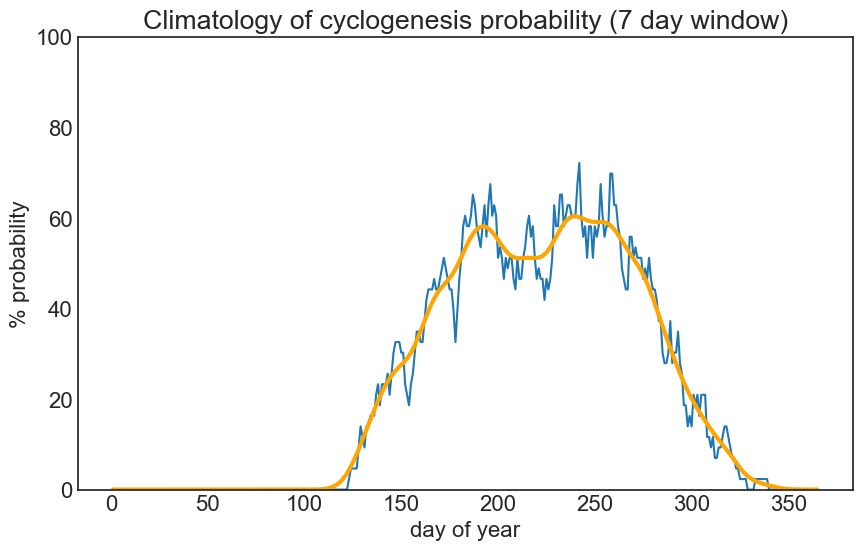

In [4]:
# build the data
df_data = build_data.build_data(settings)

In [5]:
df_data.columns

Index(['year', 'month', 'day', 'rmm1', 'rmm2', 'phase', 'amplitude', 'u_data',
       'sst_data', 'diy', 'date', 'enso_index', 'qbo_index', 'nhurr',
       'nhurr_roll', 'cyclogensis_boolean', 'cyclogensis_smooth_climo',
       'cyclogensis_raw_climo', 'cyclogensis_anom',
       'cyclogensis_reference_frequency', 'nhurr_roll_smooth_climo',
       'nhurr_roll_raw_climo', 'nhurr_roll_anom',
       'nhurr_roll_reference_frequency', 'hurr_counts',
       'hurr_counts_smoothed'],
      dtype='object')

In [6]:
meses = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec", "Jan"]

In [7]:
legend_font = 20
title_font = 32
axis_font = 22

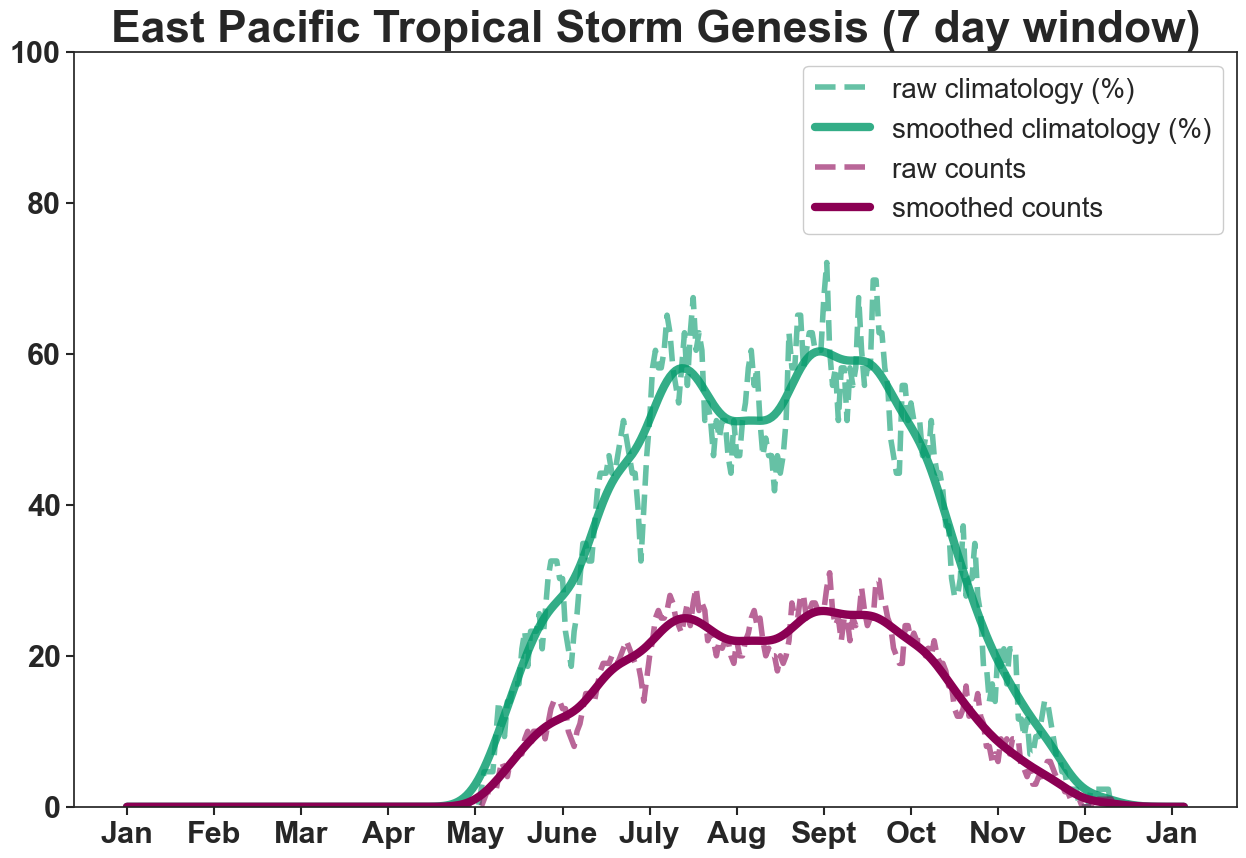

In [8]:
plt.figure(figsize = (15,10))
ax = plt.axes()
plt.plot(df_data['cyclogensis_raw_climo'][:365]*100, '--' ,color = colors[1], lw = 4, alpha = .6, label = 'raw climatology (%)')
plt.plot(df_data['cyclogensis_smooth_climo'][:365]*100, color = colors[1], lw = 6, alpha = .8, label = 'smoothed climatology (%)')
plt.plot(df_data['hurr_counts'][:365],'--', color = colors[2], lw = 4, alpha = 0.6, label = 'raw counts')
plt.plot(df_data['hurr_counts_smoothed'][:365].values, color = colors[2], lw = 6, label = 'smoothed counts')
plt.title("East Pacific Tropical Storm Genesis (7 day window)", fontsize = title_font, weight ='bold')
plt.ylim(0,100)
plt.legend(facecolor='white', framealpha=1, frameon=True, fontsize=legend_font)
plt.xticks(np.arange(0,365,30), meses, fontsize=axis_font, weight ='bold')
plt.yticks(fontsize = axis_font, weight ='bold')
ax.tick_params(axis = 'both',direction='out', length=6, width=1.5)
# plt.savefig('/Users/zfrontera/Library/CloudStorage/GoogleDrive-zcf.atmos@gmail.com/My Drive/WORK/research/phase_7/s2s_hurricane_prediction-main/figures/Pacific_Clims&Counts_lowres.png', dpi=150,facecolor='white', transparent=False,bbox_inches='tight')
plt.show()

# Train Model(s)

In [9]:
# get year splits for validation
val_year_split = make_features_labels.get_val_years(settings, df_data)
# val_year_split = val_year_split[3:4]
pprint.pprint(val_year_split)

[array([1987, 1979, 2011, 1982, 1980, 2001, 2012]),
 array([2016, 1989, 2017, 2021, 2000, 1996]),
 array([1988, 2015, 2006, 1981, 1993, 2010]),
 array([1995, 1994, 2008, 2007, 1990, 1983]),
 array([2020, 2005, 2014, 2009, 1985, 2004]),
 array([2003, 2018, 1991, 2019, 1986, 1992]),
 array([1997, 1999, 1998, 1984, 2013, 2002])]


In [10]:
# val_year = np.concatenate(val_year_split)

# TEST_YEAR = 2018

# val_year_new = np.where(val_year!=TEST_YEAR,val_year, np.nan)

# shuffled_years = val_year_new[~np.isnan(val_year_new)]

# val_year_split = np.array_split(shuffled_years, len(shuffled_years) / settings["n_val_years"])

# pprint.pprint(val_year_split)

In [11]:
pprint.pprint(val_year_split)

[array([1987, 1979, 2011, 1982, 1980, 2001, 2012]),
 array([2016, 1989, 2017, 2021, 2000, 1996]),
 array([1988, 2015, 2006, 1981, 1993, 2010]),
 array([1995, 1994, 2008, 2007, 1990, 1983]),
 array([2020, 2005, 2014, 2009, 1985, 2004]),
 array([2003, 2018, 1991, 2019, 1986, 1992]),
 array([1997, 1999, 1998, 1984, 2013, 2002])]


In [12]:
lr_coef = []
rf_importance = []
predict = []
# pred_2012 = []
shaps = []
shaps_all = []

imp.reload(build_model)
df_metrics = pd.DataFrame()

for leadtime in settings["leadtimes"]:
    print('---- leadtime ' + str(leadtime) + ' days ----')
    settings['leadtime'] = leadtime

    # REMEMBER TO INCLUDE BASELINE! IT NEEDS IT TO COMPUTE THE DIFFERENCES

    for features_type in ("baseline","enso","rmm","all_rmm","all_rmm_rmm-7","all_rmm_rmm-7_uwind_sst", 
                         ):
        
        print(' ' + features_type)

        metrics_dict = compute_metrics.declare_empty_metrics(len(val_year_split))
        pred = []
        for iterfold, val_years in enumerate(val_year_split):
            # get training/validation split
            settings["val_years"] = val_years
            df_data_model, df_data_train, df_data_val = make_features_labels.make_model_data(settings, df_data)

            # train the model
            x_train, y_train, x_val, y_val = make_features_labels.get_features_labels(settings,
                                                                                      features_type,
                                                                                      df_data_train,
                                                                                      df_data_val,
                                                                                      )
            # train and save model
            if settings["model_type"] == "random_forest":
                model = build_model.make_rf_classifier(settings)  # random forest model
            elif settings["model_type"] == "logistic_regression":
                model = build_model.make_lr_classifier(settings)  # logistic regression model
            elif settings["model_type"] == "mlp":
                model = build_model.make_mlp_classifier(settings)  # support vector machine model
            else:
                raise NotImplementedError("no such model yet implemented.")
                
            model.fit(x_train, y_train)
            
            exp_filename = save_load_model.get_exp_filename(settings["exp_name"],
                                                            settings["leadtime"],
                                                            features_type,
                                                            iterfold)
            if SAVE_MODEL:
                save_load_model.save_model(exp_filename, model)

            # compute metrics for validation data
            metrics_dict = compute_metrics.compute_metrics(metrics_dict, iterfold, model, x_train, y_train, x_val, y_val)
            
            # LR coefficients and feature importance and confusion matrix
#             if settings["model_type"] == "logistic_regression":
#                 if leadtime == settings["leadtimes"][0] or leadtime == settings["leadtimes"][1]:# or leadtime == settings["leadtimes"][len(settings["leadtimes"])-1]:
                    
#             predict.append(model.predict(x_val)) #to compare these results with yval!
            
            
#             if features_type == "all_rmm_rmm-7_uwind_sst":
                
#                 prueba_info = make_features_labels.make_prueba_data(settings,df_data)
#                 prueba = prueba_info.where(prueba_info['year'] == TEST_YEAR).dropna().reset_index()
# #                 print(prueba.columns)
#                 prueba_feats = prueba[["label_hurr_counts", "enso_index", "rmm1", "rmm2", "rmm1-7", "rmm2-7","u_data", "sst_data"]]
#                 prueba_feats_arr = np.array(prueba_feats)
#                 pred_2012 = model.predict(prueba_feats_arr)
#                 real_pred_2012 = df_data.where(df_data['year']==TEST_YEAR).dropna().reset_index()
#                 pred.append(pred_2012)
                
#                 pd.options.mode.chained_assignment = None  # default='warn'
#                 for ones in range(0,len(real_pred_2012)):
#                     if real_pred_2012['nhurr_roll'][ones] >= 2.0:
#                         real_pred_2012['nhurr_roll'][ones] = 1.0
                
#                 if iterfold == 6: 
#                     xval_years = val_years
#                     fold_means = np.array(pred).T
#                     fold_mean_pred = fold_means.mean(axis=1)

#                     plt.figure(figsize = [10,8])
#                     ax = plt.axes()
#                     plt.plot(np.arange(89,272),real_pred_2012['nhurr_roll'][119:-63].values, 'o', color = colors[2], markeredgecolor="gray", alpha = .8, label = 'real')
#                     plt.plot(np.arange(89,272),fold_mean_pred-.01, 'o', color = colors[1], alpha = .8,  markeredgecolor="gray", label = 'prediction')
#                     plt.title("LR Predicted Values for "+ str(TEST_YEAR) + " with a Leadtime of "+ str(leadtime))
#                     plt.legend(facecolor='white', framealpha=1, frameon=True, fontsize=12)
#                     plt.xticks(np.arange(89,272,30), ['Apr','May','Jun','Jul','Aug','Sep','Oct'], fontsize=14)
#                     plt.yticks([0,1],fontsize = 15)
#                     ax.tick_params(axis = 'both',direction='out', length=6, width=1.5)
# #                     plt.savefig('/Users/zfrontera/Library/CloudStorage/GoogleDrive-zcf.atmos@gmail.com/My Drive/WORK/research/phase_7/s2s_hurricane_prediction-main/figures/Pacific_LR_leadtime_'+str(leadtime)+'_'+str(TEST_YEAR)+'proba.png', dpi=500,facecolor='white', transparent=False)
#                     plt.show()
            
#                 elif iterfold == 0: #fold donde este en el test_year
                
#                     explainer = shap.LinearExplainer(model,x_train,feature_perturbation="interventional")
#                     shap_values = explainer.shap_values(x_val)
#                     shap.summary_plot(shap_values, x_val, feature_names=["label_cyclogensis_smooth_climo", "enso_index", "rmm1", "rmm2", "rmm1-7", "rmm2-7","u_data", "sst_data"],show=False, plot_type = "bar")
#                     plt.savefig("figures/LR_shap_summary_Pacific_"+ str(leadtime) +".png",dpi=400,bbox_inches='tight')
#                     plt.show()

#                     shaps.append(np.abs(shap_values).mean(axis=0))
#                     shaps_all.append(shap_values)

                    
                    
#                     cm = sklearn.metrics.confusion_matrix(y_val, model.predict(x_val))
#                     lr_coef.append(model.coef_)
#                     plt.figure(figsize=(9,9))
#                     sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
#                     plt.ylabel('Actual label');
#                     plt.xlabel('Predicted label');
#                     all_sample_title = 'Accuracy Score: {0}'.format(score)
#                     plt.title(all_sample_title, size = 15);      



        # save metrics
        settings["n_folds"] = iterfold + 1
        d = {'exp_name': settings["exp_name"],
             'leadtime': settings['leadtime'],
             'features_type': features_type,
             'x_train.shape': x_train.shape[0],
             'x_val.shape': x_val.shape[0],
             }
        metrics_dict.update(d)
        df_metrics = pd.concat([df_metrics, pd.DataFrame(data=metrics_dict)]).reset_index(drop=True)
        
#         if features_type == "all_rmm_rmm-7_uwind_sst" and iterfold == 0:
            
#             explainer = shap.LinearExplainer(model,x_train,feature_perturbation="interventional")
#             shap_values = explainer.shap_values(x_val)
#             shap.summary_plot(shap_values, x_val, feature_names=["label_cyclogensis_smooth_climo", "enso_index", "rmm1", "rmm2", "rmm1-7", "rmm2-7","u_data", "sst_data"],show=False, plot_type = "bar")
#             plt.savefig("figures/LR_shap_summary_Pacific_"+ str(leadtime) +".png",dpi=400,bbox_inches='tight')
#             plt.show()
            
#             shaps.append(np.abs(shap_values).mean(axis=0))
#             shaps_all.append(shap_values)

# add metrics that are defined as differences from the baseline
df_metrics = compute_metrics.add_difference_metrics(df_metrics)

# save metrics dataframe
if SAVE_METRICS:
    exp_filename = save_load_model.get_exp_filename(settings["exp_name"])
    df_metrics.to_csv('saved_metrics/metrics_' + exp_filename + '_counts.csv')

imp.reload(plot_diagnostics)
plot_diagnostics.plot_metrics(settings, df_metrics, show_plots = False)

print('training and validation COMPLETE.')       

---- leadtime 0 days ----
 baseline
 enso
 rmm
 all_rmm
 all_rmm_rmm-7
 all_rmm_rmm-7_uwind_sst
---- leadtime 7 days ----
 baseline
 enso
 rmm
 all_rmm
 all_rmm_rmm-7
 all_rmm_rmm-7_uwind_sst
---- leadtime 14 days ----
 baseline
 enso
 rmm
 all_rmm
 all_rmm_rmm-7
 all_rmm_rmm-7_uwind_sst
---- leadtime 21 days ----
 baseline
 enso
 rmm
 all_rmm
 all_rmm_rmm-7
 all_rmm_rmm-7_uwind_sst
---- leadtime 28 days ----
 baseline
 enso
 rmm
 all_rmm
 all_rmm_rmm-7
 all_rmm_rmm-7_uwind_sst
---- leadtime 35 days ----
 baseline
 enso
 rmm
 all_rmm
 all_rmm_rmm-7
 all_rmm_rmm-7_uwind_sst
---- leadtime 42 days ----
 baseline
 enso
 rmm
 all_rmm
 all_rmm_rmm-7
 all_rmm_rmm-7_uwind_sst
---- leadtime 49 days ----
 baseline
 enso
 rmm
 all_rmm
 all_rmm_rmm-7
 all_rmm_rmm-7_uwind_sst
training and validation COMPLETE.


In [24]:
fold_mean_pred.shape[0]/30

7.133333333333334

In [18]:
#                     plt.figure(figsize = [10,8])
#                     ax = plt.axes()
#                     plt.plot(real_pred_2012['nhurr_roll'][(366-(fold_mean_pred.shape[0])):-31].values, 'o', color = colors[2], markeredgecolor="gray", alpha = .8, label = 'real')
#                     plt.plot(fold_mean_pred-.01, 'o', color = colors[1], alpha = .8,  markeredgecolor="gray", label = 'prediction')
#                     plt.title("LR Predicted Values for "+ str(TEST_YEAR) + " with a Leadtime of "+ str(leadtime))
#                     plt.legend(facecolor='white', framealpha=1, frameon=True, fontsize=12)
# #                     plt.xticks(np.arange(0,fold_mean_pred.shape[0],30), ['May','Jun','Jul','Aug','Sep','Oct','Nov'], fontsize=14)
#                     plt.yticks([0,1],fontsize = 15)
#                     ax.tick_params(axis = 'both',direction='out', length=6, width=1.5)
# #                     plt.savefig('/Users/zfrontera/Library/CloudStorage/GoogleDrive-zcf.atmos@gmail.com/My Drive/WORK/research/phase_7/s2s_hurricane_prediction-main/figures/Pacific_LR_leadtime_'+str(leadtime)+'_'+str(TEST_YEAR)+'proba.png', dpi=500,facecolor='white', transparent=False)
#                     plt.show()

#### A tuple of (row_values, row_expected_values, row_mask_shapes), where row_values is an array of the attribution values for each sample, row_expected_values is an array (or single value) representing the expected value of the model for each sample (which is the same for all samples unless there are fixed inputs present, like labels when explaining the loss), and row_mask_shapes is a list of all the input shapes (since the row_values is always flattened),

In [12]:
x_val.shape

(1098, 8)

In [13]:
np.array(shaps_all).shape[0]

10

In [14]:
week1_shap = shaps_all[0]

In [15]:
week1_shap

array([[-6.26999031e-01, -1.96385495e-03,  8.48146814e-01, ...,
         2.29414950e-02,  1.84255155e-01,  3.05999870e-02],
       [-1.02174957e+00, -1.96385495e-03,  9.83799690e-01, ...,
         2.28735410e-02,  2.26108498e-01, -2.24046674e-02],
       [-1.15333308e+00, -1.96385495e-03,  1.00790914e+00, ...,
         1.67605239e-02,  3.76919048e-01, -5.84933705e-02],
       ...,
       [-2.33758469e+00,  3.24282392e-02, -3.65964337e-01, ...,
        -1.27454351e-02,  1.01082017e-01, -3.04376903e-01],
       [-2.33758469e+00,  3.24282392e-02, -4.77336704e-01, ...,
        -2.09815755e-02,  4.34097001e-02, -4.34504133e-01],
       [-2.20600118e+00,  3.24282392e-02, -5.31743799e-01, ...,
        -2.88815825e-02, -9.79776581e-02, -4.32053607e-01]])

In [16]:
df_week1 = pd.DataFrame(week1_shap, columns = ["label_cyclogensis_smooth_climo", "enso_index", "rmm1", "rmm2", "rmm1-7", "rmm2-7","u_data", "sst_data"])

In [17]:
# for i_leadtime in range(0,np.array(shaps_all).shape[0]):
#     weekly = shaps_all[i_leadtime]
#     df_week = pd.DataFrame(weekly, columns = ["label_cyclogensis_smooth_climo", "enso_index", "rmm1", "rmm2", "rmm1-7", "rmm2-7","u_data", "sst_data"])
#     plt.figure(figsize=(15, 8))
#     plt.bar(np.arange(0,183),df_week['label_cyclogensis_smooth_climo'][-183:],color = colors[0], label = 'hurr_counts')
#     plt.bar(np.arange(0,183),df_week['enso_index'][-183:],color = colors[1], label = 'enso_index')
#     plt.bar(np.arange(0,183),df_week['rmm1'][-183:],color = colors[2], label = 'rmm1')
#     plt.bar(np.arange(0,183),df_week['rmm2'][-183:],color = colors[3], label = 'rmm2')
#     plt.bar(np.arange(0,183),df_week['rmm1-7'][-183:],color = colors[4], label = 'rmm1-7')
#     plt.bar(np.arange(0,183),df_week['rmm2-7'][-183:],color = colors[5], label = 'rmm2-7')
#     plt.bar(np.arange(0,183),df_week['u_data'][-183:],color = colors[6], label = 'u_data')
#     plt.bar(np.arange(0,183),df_week['sst_data'][-183:],color = colors[7], label = 'sst_data')
#     plt.xticks(np.arange(0,183,30), ['Apr','May','Jun','Jul','Aug','Sep','Oct'], fontsize=14)
#     plt.ylabel('Variable Importance')
#     plt.title('Variable Importances for ' + str(TEST_YEAR)+' with Leadtime = '+ str(i_leadtime*7))
#     plt.legend(facecolor='white', framealpha=1, frameon=True, fontsize=12)
#     plt.savefig("figures/LR_shap_Pacific_for_"+str(TEST_YEAR)+"_"+str(i_leadtime*7)+".png",dpi=600,bbox_inches='tight',facecolor='white', transparent=False)
#     plt.show()

In [18]:
["label_cyclogensis_smooth_climo", "enso_index", "rmm1", "rmm2", "rmm1-7", "rmm2-7","u_data", "sst_data"]

['label_cyclogensis_smooth_climo',
 'enso_index',
 'rmm1',
 'rmm2',
 'rmm1-7',
 'rmm2-7',
 'u_data',
 'sst_data']

In [19]:
data = np.array([np.array([(shaps[0][0]),(shaps[1][0]),(shaps[2][0]),(shaps[3][0]),(shaps[4][0]),(shaps[5][0]),(shaps[6][0]),(shaps[7][0]),(shaps[8][0]),(shaps[9][0])]), 
np.array([(shaps[0][1]),(shaps[1][1]),(shaps[2][1]),(shaps[3][1]),(shaps[4][1]),(shaps[5][1]),(shaps[6][1]),(shaps[7][1]),(shaps[8][1]),(shaps[9][1])]),
np.array([(shaps[0][2]),(shaps[1][2]),(shaps[2][2]),(shaps[3][2]),(shaps[4][2]),(shaps[5][2]),(shaps[6][2]),(shaps[7][2]),(shaps[8][2]),(shaps[9][2])]),
np.array([(shaps[0][3]),(shaps[1][3]),(shaps[2][3]),(shaps[3][3]),(shaps[4][3]),(shaps[5][3]),(shaps[6][3]),(shaps[7][3]),(shaps[8][3]),(shaps[9][3])]),
np.array([(shaps[0][4]),(shaps[1][4]),(shaps[2][4]),(shaps[3][4]),(shaps[4][4]),(shaps[5][4]),(shaps[6][4]),(shaps[7][4]),(shaps[8][4]),(shaps[9][4])]),
np.array([(shaps[0][5]),(shaps[1][5]),(shaps[2][5]),(shaps[3][5]),(shaps[4][5]),(shaps[5][5]),(shaps[6][5]),(shaps[7][5]),(shaps[8][5]),(shaps[9][5])]),
np.array([(shaps[0][6]),(shaps[1][6]),(shaps[2][6]),(shaps[3][6]),(shaps[4][6]),(shaps[5][6]),(shaps[6][6]),(shaps[7][6]),(shaps[8][6]),(shaps[9][6])]),
np.array([(shaps[0][7]),(shaps[1][7]),(shaps[2][7]),(shaps[3][7]),(shaps[4][7]),(shaps[5][7]),(shaps[6][7]),(shaps[7][7]),(shaps[8][7]),(shaps[9][7])])])
                    

In [20]:
data.T.shape


(10, 8)

In [21]:
imps = pd.DataFrame(data.T,columns = ["label_cyclogensis_smooth_climo", "enso_index", "rmm1", "rmm2", "rmm1-7", "rmm2-7","u_data", "sst_data"])

# np.array([(shaps[0][1]),(shaps[1][1]),(shaps[2][1]),(shaps[3][1]),(shaps[4][1]),(shaps[5][1]),(shaps[6][1]),(shaps[7][1]),(shaps[8][1]),(shaps[9][1])])
# np.array([(shaps[0][0]),(shaps[1][0]),(shaps[2][0]),(shaps[3][0]),(shaps[4][0]),(shaps[5][0]),(shaps[6][0]),(shaps[7][0]),(shaps[8][0]),(shaps[9][0])])

In [22]:
imps

,label_cyclogensis_smooth_climo,enso_index,rmm1,rmm2,rmm1-7,rmm2-7,u_data,sst_data
0,0.911006,0.020112,0.355218,0.065153,0.402107,0.012237,0.243687,0.224840
1,0.867201,0.129632,0.018925,0.071791,0.123493,0.046534,0.085360,0.329563
2,0.867777,0.088187,0.191905,0.162726,0.044258,0.115358,0.154108,0.232933
3,0.841717,0.002002,0.128330,0.095065,0.025593,0.021805,0.065466,0.119667
4,0.834951,0.071591,0.091171,0.114169,0.060840,0.019439,0.033935,0.040182
5,0.828502,0.040430,0.120864,0.020156,0.067628,0.008721,0.129340,0.133461
6,0.820551,0.032484,0.023126,0.039438,0.024682,0.048178,0.077454,0.119826
7,0.814228,0.051644,0.033293,0.007461,0.006055,0.032318,0.006613,0.079296
8,0.827093,0.053484,0.013506,0.012562,0.053309,0.055548,0.004398,0.078697
9,0.832462,0.028597,0.006605,0.017633,0.052104,0.019727,0.098055,0.107477


In [23]:
# np.sum(imps.iloc[0])

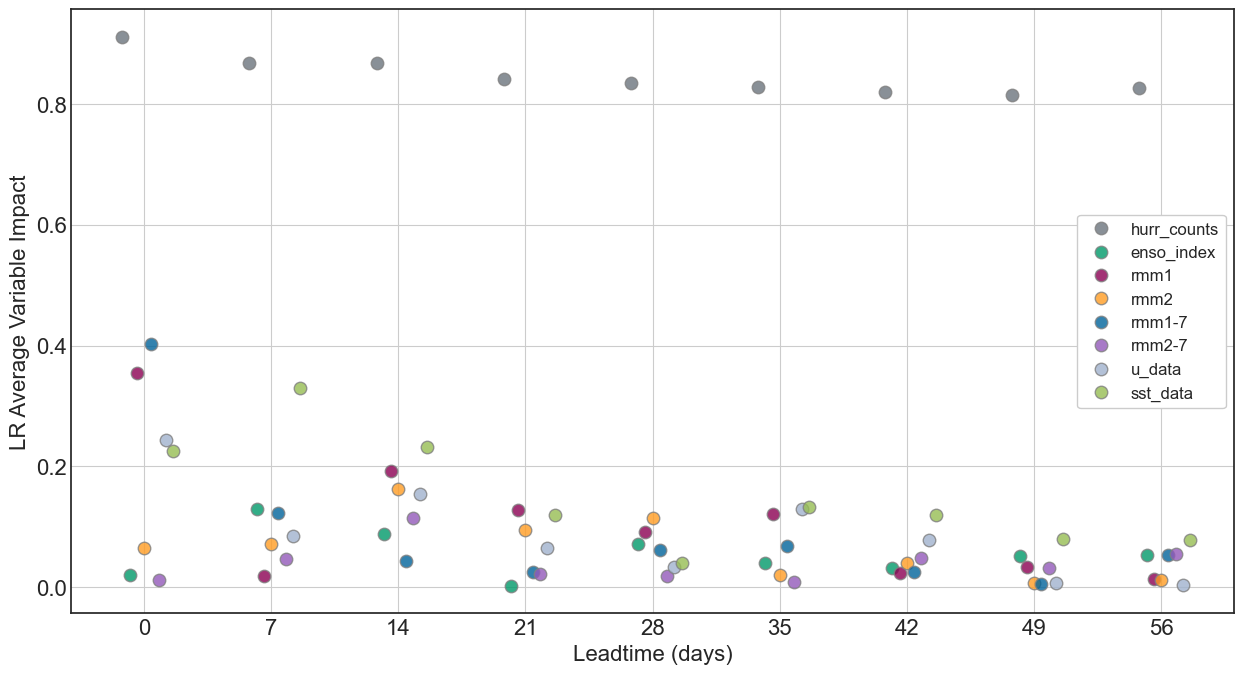

In [24]:
plt.figure(figsize=(15, 8))
plt.plot(np.arange(0,7*10,7)-1.2,imps['label_cyclogensis_smooth_climo'],'o', markeredgecolor="gray",color = colors[0], markersize=9, alpha = .8, label ='hurr_counts')
plt.plot(np.arange(0,7*10,7)-.8,imps['enso_index'],'o',markeredgecolor="gray", color = colors[1], markersize=9, alpha = .8, label ='enso_index')
plt.plot(np.arange(0,7*10,7)-.4,imps['rmm1'],'o',markeredgecolor="gray", color = colors[2], markersize=9, alpha = .8, label ='rmm1')
plt.plot(np.arange(0,7*10,7),imps['rmm2'],'o',markeredgecolor="gray", color = colors[3],  markersize=9, alpha = .8, label ='rmm2')
plt.plot(np.arange(0,7*10,7)+.4,imps['rmm1-7'],'o',markeredgecolor="gray", color = colors[4],  markersize=9, alpha = .8, label ='rmm1-7')
plt.plot(np.arange(0,7*10,7)+.8,imps['rmm2-7'],'o',markeredgecolor="gray", color = colors[5],  markersize=9, alpha = .8, label ='rmm2-7')
plt.plot(np.arange(0,7*10,7)+1.2,imps['u_data'],'o',markeredgecolor="gray", color = colors[6], markersize=9, alpha = .8, label ='u_data')
plt.plot(np.arange(0,7*10,7)+1.6,imps['sst_data'],'o',markeredgecolor="gray", color = colors[7], markersize=9, alpha = .8, label ='sst_data')
plt.legend(facecolor='white', framealpha=1, frameon=True, fontsize=12)
plt.xticks(np.arange(0,7*10,7))
plt.grid()
# plt.ylim(-.08, .14)
plt.xlim(-4,60)
plt.ylabel('LR Average Variable Impact')
plt.xlabel('Leadtime (days)')
plt.savefig("figures/LR_shap_summary_Pacific_all.png",dpi=600,bbox_inches='tight')
plt.show()

In [27]:
plt.figure(figsize=(15, 8))
plt.bar(np.arange(0,7*10,7)-1.5,imps['label_cyclogensis_smooth_climo'],color = colors[0], edgecolor="gray",alpha=.8, label ='hurr_counts')
plt.bar(np.arange(0,7*10,7)-1,imps['enso_index'],color = colors[1], edgecolor="gray",alpha=.8,label ='enso_index')
plt.bar(np.arange(0,7*10,7)-.5,imps['rmm1'],color = colors[2], edgecolor="gray",alpha=.8,label ='rmm1')
plt.bar(np.arange(0,7*10,7),imps['rmm2'],color = colors[3], edgecolor="gray",alpha=.8,label ='rmm2')
plt.bar(np.arange(0,7*10,7)+.5,imps['rmm1-7'],color = colors[4], edgecolor="gray",alpha=.8,label ='rmm1-7')
plt.bar(np.arange(0,7*10,7)+1.0,imps['rmm2-7'],color = colors[5], edgecolor="gray",alpha=.8,label ='rmm2-7')
plt.bar(np.arange(0,7*10,7)+1.5,imps['u_data'],color = colors[6], edgecolor="gray",alpha=.8,label ='u_data')
plt.bar(np.arange(0,7*10,7)+2,imps['sst_data'],color = colors[7], edgecolor="gray",alpha=.8,label ='sst_data')
plt.legend(facecolor='white', framealpha=1, frameon=True, fontsize=12)
plt.xticks(np.arange(0,7*10,7))
plt.grid()
# plt.ylim(-.08, .14)
plt.xlim(-4,60)
# plt.ylabel('LR Average Variable Impact')
plt.xlabel('Leadtime (days)')
plt.savefig("figures/LR_shap_summary_Pacific_all_bar.png",dpi=600,bbox_inches='tight',facecolor='white', transparent=False)
plt.show()

NameError: name 'imps' is not defined

<Figure size 1500x800 with 0 Axes>

In [ ]:
# np.arange(0,len(np.asarray(predict)),(7*8))

# "baseline","all_rmm_rmm-7","all_rmm_rmm-7_uwind","all_uwind","uwind", 
#                           "all_uwind_sst", "all_rmm_rmm-7_sst", "all_rmm_rmm-7_uwind_sst",

# Example analysis scripts

In [13]:
df_metrics

,iterfold,accuracy,matthews_corrcoef,f1_score,precision,recall,avg_precision_score,brier_score,brier_skill_score,exp_name,leadtime,features_type,x_train.shape,x_val.shape,brier_skill_score_baseline_diff,accuracy_baseline_diff,f1_score_baseline_diff
0,0.0,0.657543,0.291331,0.571429,0.531056,0.618445,0.469283,0.200083,0.141155,exp000,0,baseline,7918,1284,0.000000,0.000000,0.000000
1,1.0,0.679128,0.338701,0.607619,0.577899,0.640562,0.509588,0.203847,0.141994,exp000,0,baseline,7918,1284,0.000000,0.000000,0.000000
2,2.0,0.662773,0.304484,0.561297,0.491135,0.654846,0.435325,0.199670,0.108463,exp000,0,baseline,7918,1284,0.000000,0.000000,0.000000
3,3.0,0.676012,0.330655,0.586481,0.528674,0.658482,0.467281,0.189837,0.168245,exp000,0,baseline,7918,1284,0.000000,0.000000,0.000000
4,4.0,0.716511,0.415585,0.656604,0.644444,0.669231,0.565238,0.188272,0.222114,exp000,0,baseline,7918,1284,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,2.0,0.657321,0.273159,0.535865,0.483810,0.600473,0.422134,0.199007,0.111424,exp000,49,all_rmm_rmm-7_uwind_sst,7918,1284,0.002961,-0.005452,-0.025432
332,3.0,0.690031,0.343950,0.587992,0.548263,0.633929,0.475285,0.188264,0.175136,exp000,49,all_rmm_rmm-7_uwind_sst,7918,1284,0.006891,0.014019,0.001511
333,4.0,0.708723,0.389845,0.628231,0.650206,0.607692,0.554004,0.188622,0.220671,exp000,49,all_rmm_rmm-7_uwind_sst,7918,1284,-0.001444,-0.007788,-0.028373
334,5.0,0.660436,0.296420,0.581574,0.596457,0.567416,0.518345,0.198922,0.187972,exp000,49,all_rmm_rmm-7_uwind_sst,7918,1284,-0.000983,-0.001558,-0.014329


In [14]:
feats = ["baseline","enso","rmm","all_rmm","all_rmm_rmm-7","all_rmm_rmm-7_uwind_sst"]

In [15]:
baseline = df_metrics.where(df_metrics['features_type'] == feats[0]).dropna().reset_index(drop=True)
enso = df_metrics.where(df_metrics['features_type'] == feats[1]).dropna().reset_index(drop=True)
rmm = df_metrics.where(df_metrics['features_type'] == feats[2]).dropna().reset_index(drop=True)
all_rmm = df_metrics.where(df_metrics['features_type'] == feats[3]).dropna().reset_index(drop=True)
all_rmm_7 = df_metrics.where(df_metrics['features_type'] == feats[4]).dropna().reset_index(drop=True)
all_rmm_7_uwind_sst = df_metrics.where(df_metrics['features_type'] == feats[5]).dropna().reset_index(drop=True)

In [16]:
baseline_means = []
enso_means = []
rmm_means = []
all_rmm_means = []
all_rmm_7_means = []
all_rmm_7_uwind_sst_means = []

baseline_folds = []
enso_folds = []
rmm_folds = []
all_rmm_folds = []
all_rmm_7_folds = []
all_rmm_7_uwind_sst_folds = []

In [17]:
for j in np.arange(0,len(baseline),7):
    baseline_means.append(np.mean(baseline['brier_skill_score'][j:j+6].values))
    enso_means.append(np.mean(enso['brier_skill_score'][j:j+6].values))
    rmm_means.append(np.mean(rmm['brier_skill_score'][j:j+6].values))
    all_rmm_means.append(np.mean(all_rmm['brier_skill_score'][j:j+6].values))
    all_rmm_7_means.append(np.mean(all_rmm_7['brier_skill_score'][j:j+6].values))
    all_rmm_7_uwind_sst_means.append(np.mean(all_rmm_7_uwind_sst['brier_skill_score'][j:j+6].values))
    
    baseline_folds.append((baseline['brier_skill_score'][j:j+6].values))
    enso_folds.append((enso['brier_skill_score'][j:j+6].values))
    rmm_folds.append((rmm['brier_skill_score'][j:j+6].values))
    all_rmm_folds.append((all_rmm['brier_skill_score'][j:j+6].values))
    all_rmm_7_folds.append((all_rmm_7['brier_skill_score'][j:j+6].values))
    all_rmm_7_uwind_sst_folds.append((all_rmm_7_uwind_sst['brier_skill_score'][j:j+6].values))

In [18]:
min(np.concatenate(np.array(baseline_folds)))

0.1084632689315661

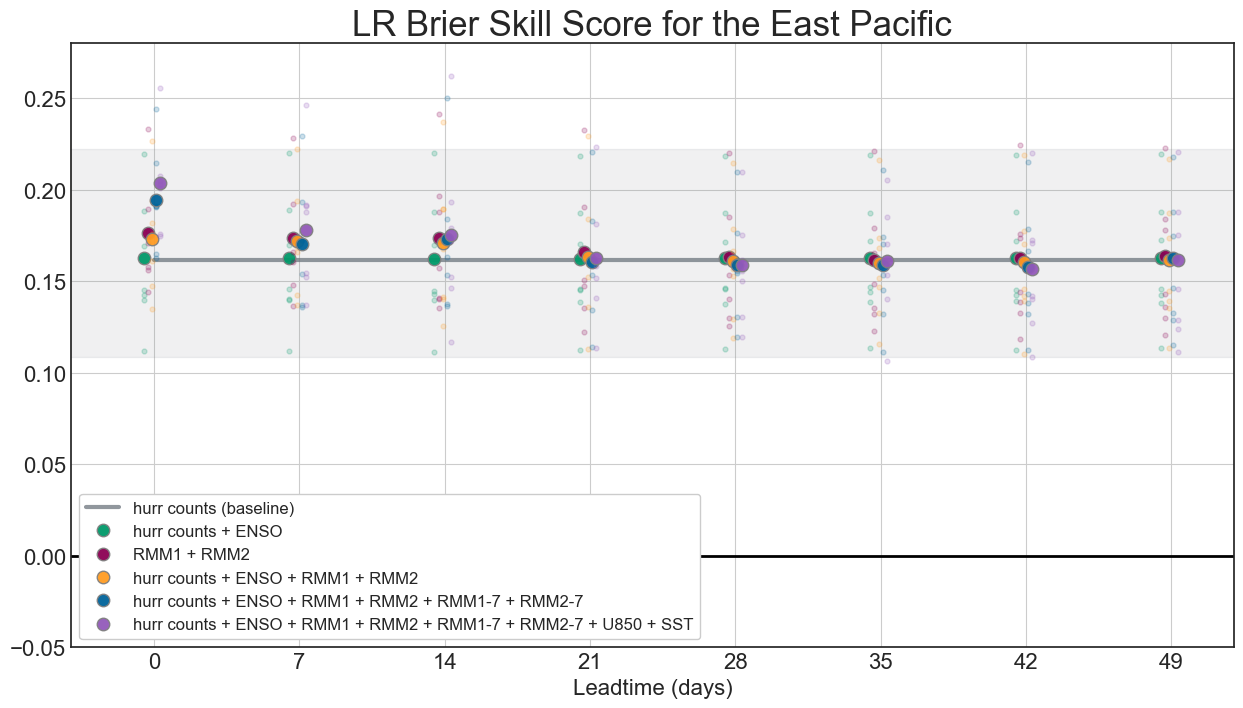

In [19]:
plt.figure(figsize=(15, 8))

plt.fill_between(np.arange(-10,7*8,7), min(np.concatenate(np.array(baseline_folds))), max(np.concatenate(np.array(baseline_folds))), color= colors[0],alpha=.1)
plt.plot(np.arange(0,7*8,7), baseline_means, color=colors[0],linewidth=3, alpha=.75, label = 'hurr counts (baseline)')

plt.plot(baseline['leadtime']-.5, enso['brier_skill_score'],'.', color = colors[1], markersize=7, alpha = .2)
plt.plot(np.arange(0,7*8,7)-.5,enso_means,'o',color = colors[1], markeredgecolor="gray", markersize=9, alpha = .95, label = 'hurr counts + ENSO')

plt.plot(baseline['leadtime']-.3, rmm['brier_skill_score'],'.', color = colors[2], markersize=7, alpha = .2)
plt.plot(np.arange(0,7*8,7)-.3,rmm_means,'o',color = colors[2], markeredgecolor="gray", markersize=9, alpha = .95, label = 'RMM1 + RMM2')

plt.plot(baseline['leadtime']-.1, all_rmm['brier_skill_score'],'.', color = colors[3], markersize=7, alpha = .2)
plt.plot(np.arange(0,7*8,7)-.1,all_rmm_means,'o',color = colors[3], markeredgecolor="gray", markersize=9, alpha = .95, label = 'hurr counts + ENSO + RMM1 + RMM2')

plt.plot(baseline['leadtime']+.1, all_rmm_7['brier_skill_score'],'.', color = colors[4], markersize=7, alpha = .2)
plt.plot(np.arange(0,7*8,7)+.1,all_rmm_7_means,'o',color = colors[4], markeredgecolor="gray", markersize=9, alpha = .95, label = 'hurr counts + ENSO + RMM1 + RMM2 + RMM1-7 + RMM2-7')

plt.plot(baseline['leadtime']+.3, all_rmm_7_uwind_sst['brier_skill_score'],'.', color = colors[5], markersize=7, alpha = .2)
plt.plot(np.arange(0,7*8,7)+.3,all_rmm_7_uwind_sst_means,'o',color = colors[5], markeredgecolor="gray", markersize=9, alpha = .95, label = 'hurr counts + ENSO + RMM1 + RMM2 + RMM1-7 + RMM2-7 + U850 + SST')

plt.legend(facecolor='white', framealpha=1, frameon=True, fontsize=12)
plt.xticks(np.arange(0,7*10,7))
plt.grid()
plt.ylim(-.05, .28)
plt.xlim(-4,52)
plt.title('LR Brier Skill Score for the East Pacific', fontsize = 25)
plt.xlabel('Leadtime (days)')
plt.axhline(y=0, color="black", linewidth=2)
plt.savefig('/Users/zfrontera/Library/CloudStorage/GoogleDrive-zcf.atmos@gmail.com/My Drive/WORK/research/phase_7/s2s_hurricane_prediction-main/figures/Pacific_LR_BrierSkillScore_folds.png', dpi=200, bbox_inches='tight')
plt.show()

In [20]:
np.array(enso_means)-np.array(baseline_means)

array([0.00076223, 0.00103785, 0.00051276, 0.00042583, 0.00073437,
       0.00121193, 0.0010026 , 0.00111422])

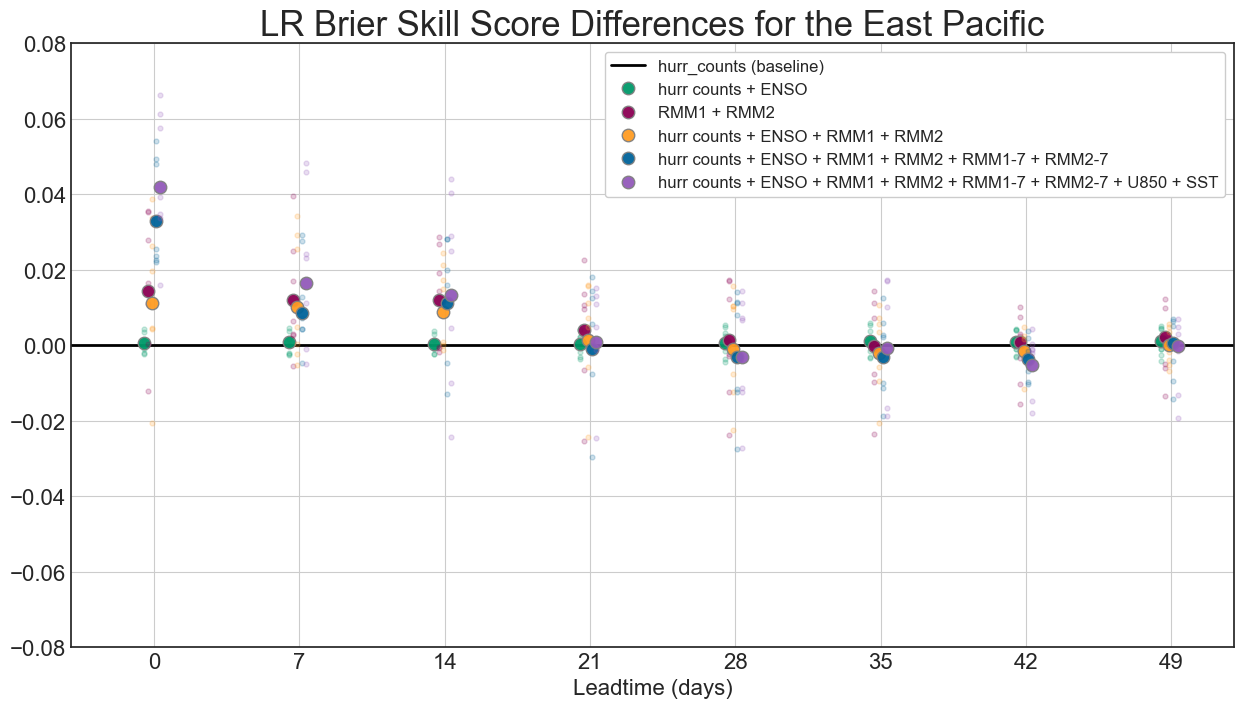

In [21]:
plt.figure(figsize=(15, 8))

plt.axhline(y=0, color="black", linewidth=2, label = 'hurr_counts (baseline)')

plt.plot(baseline['leadtime']-.5, enso['brier_skill_score']-baseline['brier_skill_score'],'.', color = colors[1], markersize=7, alpha = .2)
plt.plot(np.arange(0,7*8,7)-.5,np.array(enso_means)-np.array(baseline_means),'o',color = colors[1], markeredgecolor="gray", markersize=9, alpha = .95, label = 'hurr counts + ENSO')

plt.plot(baseline['leadtime']-.3, rmm['brier_skill_score']-baseline['brier_skill_score'],'.', color = colors[2], markersize=7, alpha = .2)
plt.plot(np.arange(0,7*8,7)-.3,np.array(rmm_means)-np.array(baseline_means),'o',color = colors[2], markeredgecolor="gray", markersize=9, alpha = .95, label = 'RMM1 + RMM2')

plt.plot(baseline['leadtime']-.1, all_rmm['brier_skill_score']-baseline['brier_skill_score'],'.', color = colors[3], markersize=7, alpha = .2)
plt.plot(np.arange(0,7*8,7)-.1,np.array(all_rmm_means)-np.array(baseline_means),'o',color = colors[3], markeredgecolor="gray", markersize=9, alpha = .95, label = 'hurr counts + ENSO + RMM1 + RMM2')

plt.plot(baseline['leadtime']+.1, all_rmm_7['brier_skill_score']-baseline['brier_skill_score'],'.', color = colors[4], markersize=7, alpha = .2)
plt.plot(np.arange(0,7*8,7)+.1,np.array(all_rmm_7_means)-np.array(baseline_means),'o',color = colors[4], markeredgecolor="gray", markersize=9, alpha = .95, label = 'hurr counts + ENSO + RMM1 + RMM2 + RMM1-7 + RMM2-7')

plt.plot(baseline['leadtime']+.3, all_rmm_7_uwind_sst['brier_skill_score']-baseline['brier_skill_score'],'.', color = colors[5], markersize=7, alpha = .2)
plt.plot(np.arange(0,7*8,7)+.3,np.array(all_rmm_7_uwind_sst_means)-np.array(baseline_means),'o',color = colors[5], markeredgecolor="gray", markersize=9, alpha = .95, label = 'hurr counts + ENSO + RMM1 + RMM2 + RMM1-7 + RMM2-7 + U850 + SST')

plt.legend(facecolor='white', framealpha=1, frameon=True, fontsize=12)
plt.xticks(np.arange(0,7*10,7))
plt.grid()
plt.ylim(-.08, .08)
plt.xlim(-4,52)
plt.title('LR Brier Skill Score Differences for the East Pacific', fontsize = 25)
plt.xlabel('Leadtime (days)')
plt.savefig('/Users/zfrontera/Library/CloudStorage/GoogleDrive-zcf.atmos@gmail.com/My Drive/WORK/research/phase_7/s2s_hurricane_prediction-main/figures/Pacific_LR_BrierSkillScoreDifferences_folds.png', dpi=600, bbox_inches='tight')
plt.show()

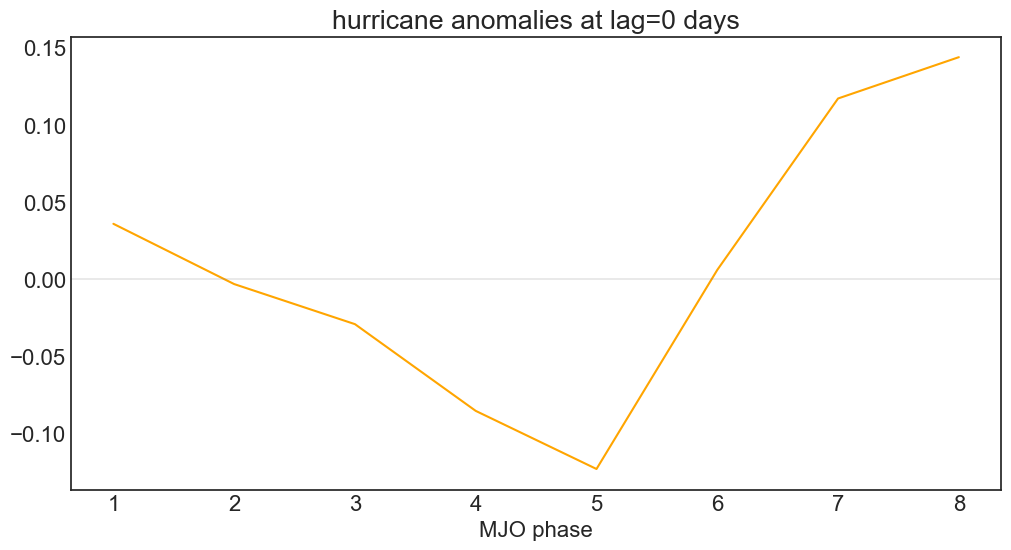

In [12]:
# Analyze anomalous number of storms (NOT boolean cyclogensis) by phase of the MJO
# Use the df_data_model to focus only on the hurricane season
# Recall that df_data has all months of the year

df = df_data_model[df_data_model["amplitude"]>=.5]
df_anoms = df.groupby('phase', as_index=False)['nhurr_roll_anom'].mean()

plt.figure(figsize=(12,6))
plt.plot(df_anoms["phase"], df_anoms["nhurr_roll_anom"], color="orange")
plt.axhline(y=0, linestyle='-', linewidth=.25, color="gray")
plt.xlabel('MJO phase')
plt.title('hurricane anomalies at lag=0 days')
# plt.ylim(-.2,.2)
plt.show()

In [ ]:
# Analyze anomalous number of storms (NOT boolean cyclogensis) by phase of the MJO
# Use the df_data_model to focus only on the hurricane season
# Recall that df_data has all months of the year

df = df_data_model[df_data_model["amplitude"]>=.5]
df_anoms = df.groupby('enso_index', as_index=False)['nhurr_roll_anom'].mean()

plt.figure(figsize=(12,6))
plt.plot(df_anoms["enso_index"], df_anoms["nhurr_roll_anom"], color="orange")
plt.axhline(y=0, linestyle='-', linewidth=.25, color="gray")
plt.xlabel('ENSO')
plt.title('hurricane anomalies at lag='  + str(leadtime) + ' days') # COMO CAMBIO EL LAG?
# plt.ylim(-.2,.2)
plt.show()

In [ ]:
df_data_model.columns

In [ ]:
(np.sum(df_data_model['label_cyclogensis_boolean']))

In [ ]:
# load_model('exp000_leadtime_0_featurestype_all_mjo_iterfold_0.jbl.lzma')